# CREATE A COPY FIRST!

## **Question 2: Arabic Handwritten Character Search**

Ali’s younger brother is learning to write Arabic characters. One day, he wrote a character that looks like **"ب"**, and Ali wants to find **the most similar 5 images** from a dataset of handwritten Arabic characters.

📝 **Your Task:**  
Complete the missing code cells below by implementing **image search** to find the most similar 5 images to the given input character.  



# Download Data

### Query Image

In [1]:
# # Please uncomment this out when you are running this lab on google colab!
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

100%|██████████| 320/320 [00:00<00:00, 243kB/s]

Extracting files...


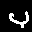

In [2]:
import kagglehub
from PIL import Image
import os

path = kagglehub.dataset_download("mohammad2012191/character")
raw_query_image = Image.open(os.path.join(path,"char.png"))
raw_query_image

### Arabic Characters Dataset

In [3]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("mohammad2012191/arabic-chars")

print("Path to dataset files:", dataset_path)

100%|██████████| 219k/219k [00:00<00:00, 494kB/s]

Extracting files...
Path to dataset files: /content/data/datasets/mohammad2012191/arabic-chars/versions/3


# TASK 1: Complete the following code to build a custom dataset class for the data

In [4]:
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ArabicHandwritingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = glob.glob(os.path.join(root_dir, "*.png"))  # Extract all image paths: Use glob to extract images paths from root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB") # TO DO: Write a line to load the image from img_path
        label = os.path.basename(img_path).split("_")[0] # TO DO: Write a line to extract the label from img_path
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((32, 32)), # TO DO: Resize to 32*32
    transforms.ToTensor(), # TO DO: Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # TO DO: Normalize using Imagenet mean and std
])


train_dataset = ArabicHandwritingDataset(root_dir=os.path.join(dataset_path,"chars images"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)# TO DO
print(f"Total images: {len(train_dataset)}")



transformed_query_image = transform(raw_query_image).unsqueeze(0)# TO DO: Apply the transform to raw_query_image

Total images: 668


# TASK 2: Use EfficientNet B3 to extract features.

##### import using:
from torchvision.models import efficientnet_b3

### Extract Features for the dataset images

In [13]:
import torch
import torchvision.models as models
import torch.nn as nn
# TO DO: Load pretrained efficientnet_b3 model
device = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet = models.efficientnet_b3(pretrained=True)
efficientnet.eval().to(device)


# TO DO: Use efficientnet_b3 to extract features
def extract_features(image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        features = efficientnet.features(image_tensor)  # Extract features
        features = torch.flatten(features, start_dim=1)  # Flatten before passing to classifier
    return features

all_features = []
image_tensors = []

for images, _ in tqdm(train_loader):
    image_tensors.append(images)
    features = extract_features(images)
    all_features.append(features.cpu())

# TO DO: Convert features to numpy and concatenate them.
all_features = torch.cat(all_features).numpy()

# TO DO: Concatenate the raw images tensors

image_tensors = torch.cat(image_tensors)
print(f"Dataset Features Shape: {dataset_features_np.shape}")
print(f"Query Image Features Shape: {query_image_feats_np.shape}")
print(f"Raw Image Tensors Shape: {image_tensors.shape}")  # Confirm concatenation

100%|██████████| 21/21 [00:07<00:00,  2.73it/s]

Dataset Features Shape: (668, 1536)
Query Image Features Shape: (1, 1536)
Raw Image Tensors Shape: torch.Size([668, 3, 32, 32])


### Extract Features for the query image

In [24]:
### TO DO: Fix the error in this line so it extracts features from the query image successfully
query_image_feats = extract_features(transformed_query_image)

# TASK 3: Get the indices of top 5 images using Cosine Similarity

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarities = cosine_similarity(query_image_feats_np, dataset_features_np)[0]  #first row

top_indices = np.argsort(similarities)[::-1][:5]  #sort in descending order , take top 5
#print
print("Top 5 Most Similar Images:")
for i, idx in enumerate(top_indices):
    print(f"Rank {i+1}: Image Index {idx}, Similarity Score: {similarities[idx]:.4f}")


Top 5 Most Similar Images:
Rank 1: Image Index 400, Similarity Score: 0.9816
Rank 2: Image Index 549, Similarity Score: 0.9803
Rank 3: Image Index 344, Similarity Score: 0.9790
Rank 4: Image Index 217, Similarity Score: 0.9749
Rank 5: Image Index 55, Similarity Score: 0.9720


# TASK 4: Fix the errors in the following code to plot the most 5 similar images

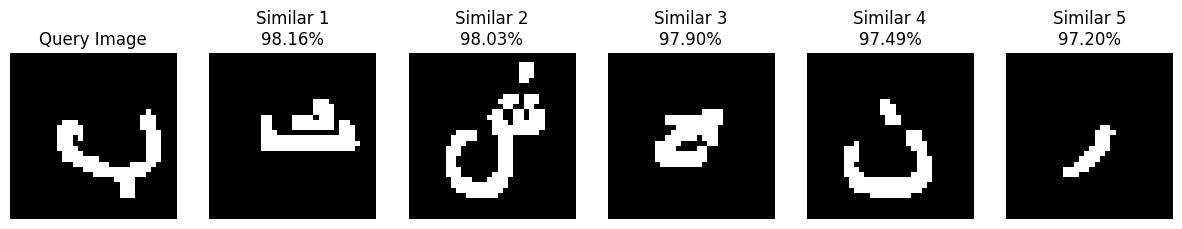

In [23]:
import matplotlib.pyplot as plt

# Display query & retrieved images with similarity scores
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

# Query image
axes[0].imshow(transformed_query_image.squeeze(0).permute(1, 2, 0).numpy())  #convert tensor to image
axes[0].set_title("Query Image")
axes[0].axis("off")

# Retrieved similar images with similarity scores
for i, idx in enumerate(top_indices):
    image = image_tensors[idx].permute(1, 2, 0).numpy()  #convert tensor to image
    similarity_score = similarities[idx]  # Get similarity score
    axes[i + 1].imshow(image)
    axes[i + 1].set_title(f"Similar {i+1}\n{100*similarity_score:.2f}%")  #Show similarity score
    axes[i + 1].axis("off")

plt.show()


# Bonus Task:  Get the indices of the most 5 *dissimilar* images and plot them

Top 5 Least Similar Images:
Rank 1: Image Index 111, Similarity Score: 0.6629
Rank 2: Image Index 640, Similarity Score: 0.6844
Rank 3: Image Index 457, Similarity Score: 0.7412
Rank 4: Image Index 298, Similarity Score: 0.7418
Rank 5: Image Index 633, Similarity Score: 0.7663


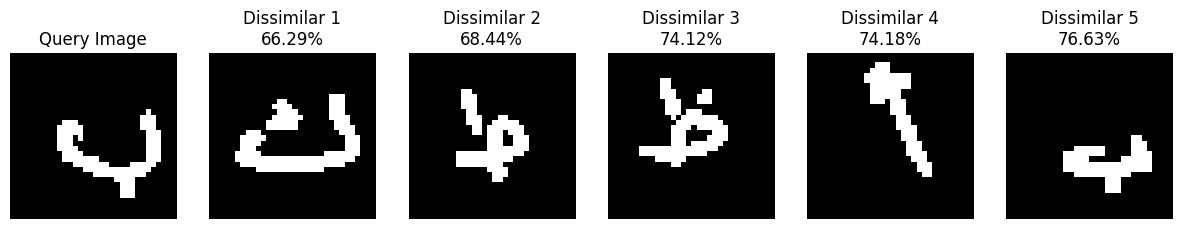

In [26]:
#Get the indices of the most 5 dissimilar images and plot them
bottom_indices = np.argsort(similarities)[:5]  #sort in ascending order and take bottom 5

#print Least Similar Images
print("Top 5 Least Similar Images:")
for i, idx in enumerate(bottom_indices):
    print(f"Rank {i+1}: Image Index {idx}, Similarity Score: {similarities[idx]:.4f}")

fig, axes = plt.subplots(1, 6, figsize=(15, 3))

#query first image
axes[0].imshow(transformed_query_image.squeeze(0).permute(1, 2, 0).numpy())  #convert tensor to image
axes[0].set_title("Query Image")
axes[0].axis("off")

#got least similar images
for i, idx in enumerate(bottom_indices):
    image = image_tensors[idx].permute(1, 2, 0).numpy()  #convert tensor to image
    similarity_score = similarities[idx]  #get similarity score

    axes[i + 1].imshow(image)  #display
    axes[i + 1].set_title(f"Dissimilar {i+1}\n{100*similarity_score:.2f}%")  #show score
    axes[i + 1].axis("off")

plt.show()
